# **Youtube Comment Category Classifier Fine Tuning Model and Evaluation**

In this section, we fine-tune and compare the performance of three transformer-based models: DistilBERT, BERT, and RoBERTa. These models were built to categorize YouTube comments into specific categories such as Product/Subject, Misc./Spam, Creator, and Video Setup. The training data, including labels, was created by extracting data from YouTube via the API in Python, and the labeling was done manually by our team. The evaluation metrics considered include evaluation loss, runtime, samples processed per second, and steps processed per second. All models were trained and evaluated on the same dataset for three epochs.


In [43]:
# Install necessary libraries
!pip install transformers
!pip install torch
!pip install datasets


In [44]:
#Getting the training data
# The training data, including labels, was created by extracting data from
# YouTube via the API in Python, and the labeling was done manually by our team

import pandas as pd

# Load your dataset from the folder
df = pd.read_csv('/content/Training_Label_Dataset_v1.csv')
df.head()


,Comment ID,Comment,Category
0,1,lets not forget that apple pay in 2014 require...,Product/Subject
1,2,here in nz 50 of retailers dont even have cont...,Misc./Spam
2,3,i will forever acknowledge this channel with t...,Creator
3,4,whenever i go to a place that doesnt take appl...,Video Setup
4,5,apple pay is so convenient secure and easy to ...,Product/Subject


Fine-tuning and evaluating the performance of transformer-based model 1: BERT

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset


# Initialize the label encoder
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training comments
train_tokens = tokenizer(train_df['Comment'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

# Tokenize the validation comments
val_tokens = tokenizer(val_df['Comment'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

# Encode the validation labels
val_labels = label_encoder.transform(val_df['Category'])

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_length):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(comment, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }

# Create the training and validation datasets
train_dataset = CustomDataset(train_df['Comment'].tolist(), train_df['Category'].tolist(), tokenizer, max_length=128)
val_dataset = CustomDataset(val_df['Comment'].tolist(), val_labels.tolist(), tokenizer, max_length=128)

# Load the pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to=[]  # Disable W&B logging if not using it
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Start training
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print("BERT Evaluation Results:", eval_results)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


BERT Evaluation Results: {'eval_loss': 0.3351784646511078, 'eval_runtime': 50.7684, 'eval_samples_per_second': 2.344, 'eval_steps_per_second': 0.295, 'epoch': 3.0}


ROC Evaluation of Fine Tuned transformer-based model 1: BERT

In [12]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np

# Get the predictions and true labels from the validation set
predictions = trainer.predict(val_dataset)
pred_probs = predictions.predictions
true_labels = predictions.label_ids

# Calculate the ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create a DataFrame to store the ROC curve data
roc_data = {
    'Model': [],
    'Class': [],
    'FPR': [],
    'TPR': [],
    'AUC': []
}

model_name = "BERT"

for i in range(n_classes):
    roc_data['Model'].append(model_name)
    roc_data['Class'].append(label_encoder.classes_[i])
    roc_data['FPR'].append(fpr[i])
    roc_data['TPR'].append(tpr[i])
    roc_data['AUC'].append(roc_auc[i])

roc_df = pd.DataFrame(roc_data)

# Print the ROC DataFrame
print(roc_df)

  Model  Class                                                FPR  \
0  BERT      0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  BERT      1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03448275...   
2  BERT      2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  BERT      3  [0.0, 0.009259259259259259, 0.0092592592592592...   

                                                 TPR       AUC  
0  [0.0, 0.06666666666666667, 0.2, 0.233333333333...  0.993633  
1  [0.0, 0.03125, 0.5625, 0.625, 0.71875, 0.8125,...  0.989943  
2  [0.0, 0.021739130434782608, 0.0652173913043478...  0.993151  
3  [0.0, 0.0, 0.18181818181818182, 0.181818181818...  0.777778  


Fine-tuning and evaluating the performance of transformer-based model 2: DistilBERT

In [13]:
# DistilBERT Model Training and Evaluation
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the training comments
train_tokens = tokenizer(train_df['Comment'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

# Tokenize the validation comments
val_tokens = tokenizer(val_df['Comment'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

# Encode the validation labels
val_labels = label_encoder.transform(val_df['Category'])

# Create the training and validation datasets
train_dataset = CustomDataset(train_df['Comment'].tolist(), train_df['Category'].tolist(), tokenizer, max_length=128)
val_dataset = CustomDataset(val_df['Comment'].tolist(), val_labels.tolist(), tokenizer, max_length=128)

# Load the pre-trained DistilBERT model with a classification head
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to=[]  # Disable W&B logging if not using it
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Start training
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print("DistilBERT Evaluation Results:", eval_results)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


DistilBERT Evaluation Results: {'eval_loss': 0.2949956953525543, 'eval_runtime': 28.1488, 'eval_samples_per_second': 4.228, 'eval_steps_per_second': 0.533, 'epoch': 3.0}


ROC Evaluation of Fine Tuned transformer-based model 2: DistilBERT

In [14]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np

# Get the predictions and true labels from the validation set
predictions = trainer.predict(val_dataset)
pred_probs = predictions.predictions
true_labels = predictions.label_ids

# Calculate the ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create a DataFrame to store the ROC curve data
roc_data = {
    'Model': [],
    'Class': [],
    'FPR': [],
    'TPR': [],
    'AUC': []
}

model_name = "DistilBERT"

for i in range(n_classes):
    roc_data['Model'].append(model_name)
    roc_data['Class'].append(label_encoder.classes_[i])
    roc_data['FPR'].append(fpr[i])
    roc_data['TPR'].append(tpr[i])
    roc_data['AUC'].append(roc_auc[i])

roc_df = pd.DataFrame(roc_data)

# Print the ROC DataFrame
print(roc_df)

        Model  Class                                                FPR  \
0  DistilBERT      0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011...   
1  DistilBERT      1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011...   
2  DistilBERT      2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  DistilBERT      3  [0.0, 0.0, 0.0, 0.009259259259259259, 0.009259...   

                                                 TPR       AUC  
0  [0.0, 0.13333333333333333, 0.16666666666666666...  0.996255  
1  [0.0, 0.03125, 0.5625, 0.625, 0.65625, 0.78125...  0.998563  
2  [0.0, 0.08695652173913043, 0.17391304347826086...  0.983919  
3  [0.0, 0.09090909090909091, 0.2727272727272727,...  0.924242  


Fine-tuning and evaluating the performance of transformer-based model 3: Roberta

In [45]:
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Category'])

# Tokenize comments
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokens = tokenizer(df['Comment'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')


import torch
from torch.utils.data import Dataset

class CommentDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokens.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = CommentDataset(tokens, df['label'].tolist())

from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

# Load the pre-trained RoBERTa model with a classification head
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to=[]  # Disable W&B logging if not using it
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

# Start training
trainer.train()

from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize the training comments
train_tokens = tokenizer(train_df['Comment'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

# Tokenize the validation comments
val_tokens = tokenizer(val_df['Comment'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

# Encode the validation labels
val_labels = label_encoder.transform(val_df['Category'])


# Create validation dataset
val_dataset = CommentDataset(val_tokens, val_labels)

# Evaluate the model
trainer.evaluate(val_dataset)

# Save the model and tokenizer
model.save_pretrained('./results')
tokenizer.save_pretrained('./results')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.json',
 './results/merges.txt',
 './results/added_tokens.json')

In [46]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize the training comments
train_tokens = tokenizer(train_df['Comment'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

# Tokenize the validation comments
val_tokens = tokenizer(val_df['Comment'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

# Encode the validation labels
val_labels = label_encoder.transform(val_df['Category'])

# Create validation dataset
val_dataset = CommentDataset(val_tokens, val_labels)

# Evaluate the model
trainer.evaluate(val_dataset)

{'eval_loss': 0.0778288021683693,
 'eval_runtime': 46.5645,
 'eval_samples_per_second': 2.556,
 'eval_steps_per_second': 0.322,
 'epoch': 3.0}

# **Save the model as Pickle files to use further **

In [47]:
import pickle
# Save the fine-tuned model, tokenizer, and label encoder using pickle
model_path = 'fine_tuned_model.pkl'
tokenizer_path = 'tokenizer.pkl'
label_encoder_path = 'label_encoder.pkl'

with open(model_path, 'wb') as model_file:
    pickle.dump(model, model_file)

with open(tokenizer_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

with open(label_encoder_path, 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

print(f'Model, tokenizer, and label encoder saved to {model_path}, {tokenizer_path}, and {label_encoder_path}')

# Load the model, tokenizer, and label encoder from the pickle file (for verification)
with open(model_path, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open(tokenizer_path, 'rb') as tokenizer_file:
    loaded_tokenizer = pickle.load(tokenizer_file)

with open(label_encoder_path, 'rb') as label_encoder_file:
    loaded_label_encoder = pickle.load(label_encoder_file)

print('Model, tokenizer, and label encoder loaded from pickle files')

Model, tokenizer, and label encoder saved to fine_tuned_model.pkl, tokenizer.pkl, and label_encoder.pkl
Model, tokenizer, and label encoder loaded from pickle files


ROC Evaluation of Fine Tuned transformer-based model 3: Roberta

In [48]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np

# Get the predictions and true labels from the validation set
predictions = trainer.predict(val_dataset)
pred_probs = predictions.predictions
true_labels = predictions.label_ids

# Calculate the ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create a DataFrame to store the ROC curve data
roc_data = {
    'Model': [],
    'Class': [],
    'FPR': [],
    'TPR': [],
    'AUC': []
}

model_name = "RoBERTa"

for i in range(n_classes):
    roc_data['Model'].append(model_name)
    roc_data['Class'].append(label_encoder.classes_[i])
    roc_data['FPR'].append(fpr[i])
    roc_data['TPR'].append(tpr[i])
    roc_data['AUC'].append(roc_auc[i])

roc_df = pd.DataFrame(roc_data)

# Print the ROC DataFrame
print(roc_df)

     Model            Class  \
0  RoBERTa          Creator   
1  RoBERTa       Misc./Spam   
2  RoBERTa  Product/Subject   
3  RoBERTa      Video Setup   

                                                 FPR  \
0  [0.0, 0.011235955056179775, 0.0112359550561797...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.046296296296296294, 0.046296...   

                                                 TPR       AUC  
0  [0.0, 0.0, 0.13333333333333333, 0.233333333333...  0.988764  
1  [0.0, 0.03125, 0.40625, 0.46875, 0.59375, 0.71...  1.000000  
2  [0.0, 0.043478260869565216, 0.0869565217391304...  1.000000  
3  [0.0, 0.09090909090909091, 0.9090909090909091,...  0.995791  


Comparison of Fine-Tuned Models: The evaluation metrics considered include evaluation loss, runtime, samples processed per second, steps processed per second, and ROC curve.

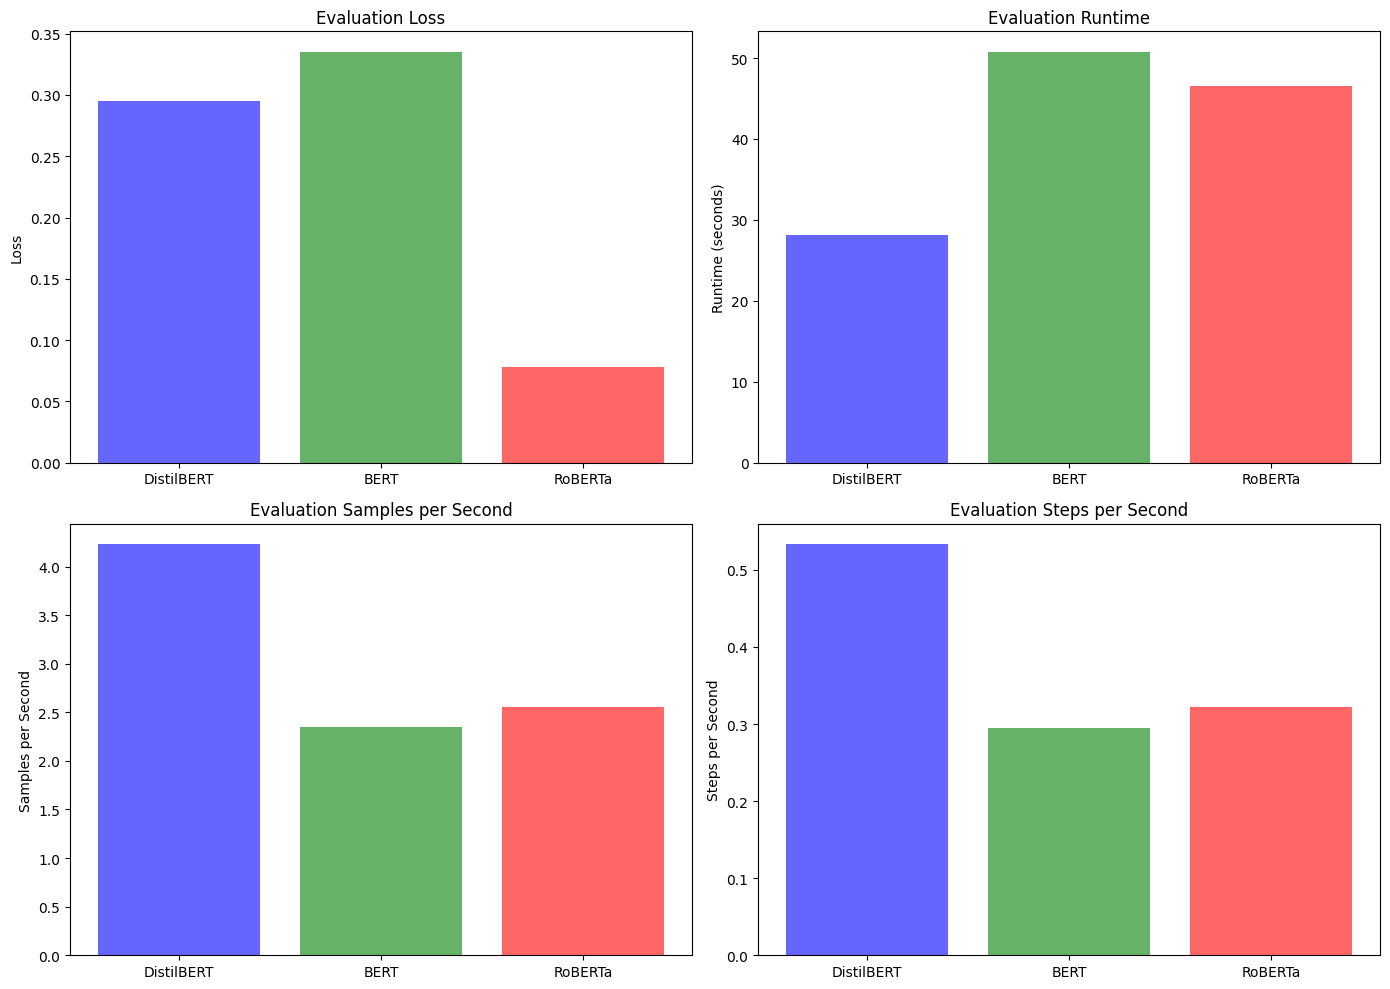

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the evaluation results for the three models with new data
distilbert_eval_results = {'eval_loss': 0.2949, 'eval_runtime': 28.14, 'eval_samples_per_second': 4.228, 'eval_steps_per_second': 0.533, 'epoch': 3.0}
bert_eval_results = {'eval_loss': 0.3351, 'eval_runtime': 50.76, 'eval_samples_per_second': 2.344, 'eval_steps_per_second': 0.295, 'epoch': 3.0}
roberta_eval_results = {'eval_loss': 0.0778288021683693, 'eval_runtime': 46.5645, 'eval_samples_per_second': 2.556, 'eval_steps_per_second': 0.322, 'epoch': 3.0}

# Create a DataFrame to compare the evaluation results
data = {
    'Metric': list(distilbert_eval_results.keys()),
    'DistilBERT': list(distilbert_eval_results.values()),
    'BERT': list(bert_eval_results.values()),
    'RoBERTa': list(roberta_eval_results.values())
}

df = pd.DataFrame(data)

# Plot the evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define colors for each model
colors = ['blue', 'green', 'red']

# Plot eval_loss
axes[0, 0].bar(['DistilBERT', 'BERT', 'RoBERTa'], [distilbert_eval_results['eval_loss'], bert_eval_results['eval_loss'], roberta_eval_results['eval_loss']], color=colors, alpha=0.6)
axes[0, 0].set_title('Evaluation Loss')
axes[0, 0].set_ylabel('Loss')

# Plot eval_runtime
axes[0, 1].bar(['DistilBERT', 'BERT', 'RoBERTa'], [distilbert_eval_results['eval_runtime'], bert_eval_results['eval_runtime'], roberta_eval_results['eval_runtime']], color=colors, alpha=0.6)
axes[0, 1].set_title('Evaluation Runtime')
axes[0, 1].set_ylabel('Runtime (seconds)')

# Plot eval_samples_per_second
axes[1, 0].bar(['DistilBERT', 'BERT', 'RoBERTa'], [distilbert_eval_results['eval_samples_per_second'], bert_eval_results['eval_samples_per_second'], roberta_eval_results['eval_samples_per_second']], color=colors, alpha=0.6)
axes[1, 0].set_title('Evaluation Samples per Second')
axes[1, 0].set_ylabel('Samples per Second')

# Plot eval_steps_per_second
axes[1, 1].bar(['DistilBERT', 'BERT', 'RoBERTa'], [distilbert_eval_results['eval_steps_per_second'], bert_eval_results['eval_steps_per_second'], roberta_eval_results['eval_steps_per_second']], color=colors, alpha=0.6)
axes[1, 1].set_title('Evaluation Steps per Second')
axes[1, 1].set_ylabel('Steps per Second')

plt.tight_layout()
plt.show()

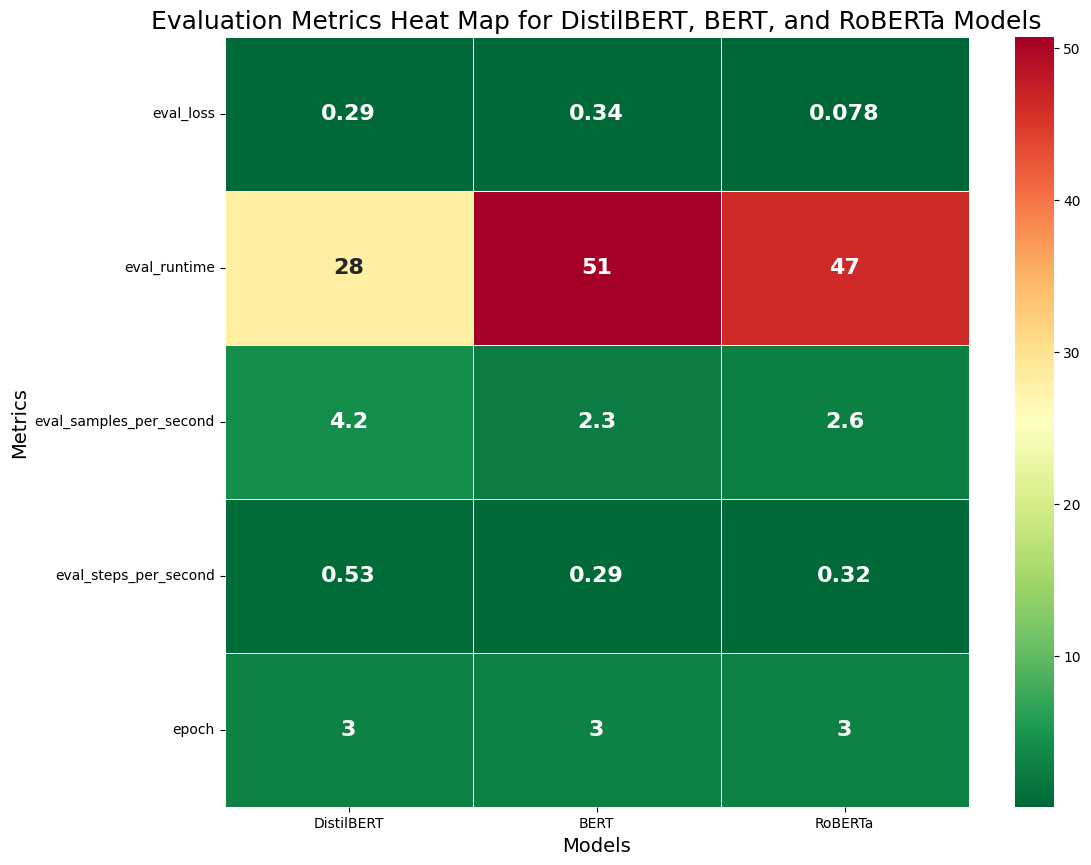


Description:
- Evaluation Loss: Lower values are better.
- Evaluation Runtime: Shorter times are better.
- Samples per Second: Higher values are better.
- Steps per Second: Higher values are better.
- Epochs: Number of epochs the model was trained for.



In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the evaluation results for the three models with new data
distilbert_eval_results = {'eval_loss': 0.2949, 'eval_runtime': 28.14, 'eval_samples_per_second': 4.228, 'eval_steps_per_second': 0.533, 'epoch': 3.0}
bert_eval_results = {'eval_loss': 0.3351, 'eval_runtime': 50.76, 'eval_samples_per_second': 2.344, 'eval_steps_per_second': 0.295, 'epoch': 3.0}
roberta_eval_results = {'eval_loss': 0.0778288021683693, 'eval_runtime': 46.5645, 'eval_samples_per_second': 2.556, 'eval_steps_per_second': 0.322, 'epoch': 3.0}

# Create a DataFrame to compare the evaluation results
data = {
    'Metric': list(distilbert_eval_results.keys()),
    'DistilBERT': list(distilbert_eval_results.values()),
    'BERT': list(bert_eval_results.values()),
    'RoBERTa': list(roberta_eval_results.values())
}

df = pd.DataFrame(data)

# Set the index to 'Metric' for better visualization
df.set_index('Metric', inplace=True)

# Create a heat map with green to red color scale and add header and description
plt.figure(figsize=(12, 10))
sns.heatmap(df, annot=True, cmap='RdYlGn_r', linewidths=.5, annot_kws={"size": 16, "weight": "bold"})
plt.title('Evaluation Metrics Heat Map for DistilBERT, BERT, and RoBERTa Models', fontsize=18)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.show()

# Add short description under the image/chart
description = """
Description:
- Evaluation Loss: Lower values are better.
- Evaluation Runtime: Shorter times are better.
- Samples per Second: Higher values are better.
- Steps per Second: Higher values are better.
- Epochs: Number of epochs the model was trained for.
"""

print(description)

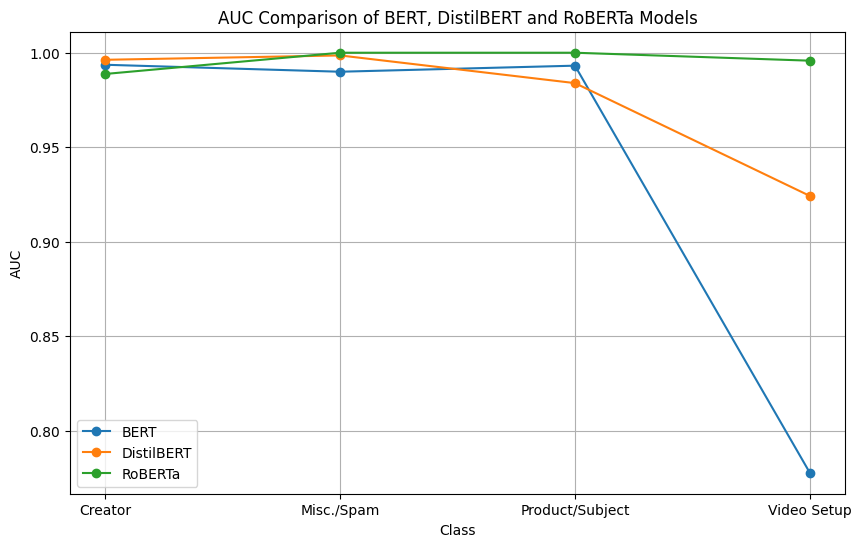

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for BERT model
bert_data = {
    'Model': ['BERT'] * 4,
    'Class': [0, 1, 2, 3],
    'AUC': [0.993633, 0.989943, 0.993151, 0.777778]
}

# Data for DistilBERT model
distilbert_data = {
    'Model': ['DistilBERT'] * 4,
    'Class': [0, 1, 2, 3],
    'AUC': [0.996255, 0.998563, 0.983919, 0.924242]
}

# Data for RoBERTa model with new ROC curve data
roberta_data = {
    'Model': ['RoBERTa'] * 4,
    'Class': ['Creator', 'Misc./Spam', 'Product/Subject', 'Video Setup'],
    'AUC': [0.988764, 1.000000, 1.000000, 0.995791]
}

# Create DataFrames
bert_df = pd.DataFrame(bert_data)
distilbert_df = pd.DataFrame(distilbert_data)
roberta_df = pd.DataFrame(roberta_data)

# Combine DataFrames for comparison
combined_df = pd.concat([bert_df, distilbert_df, roberta_df])

# Plot the AUC values for comparison
plt.figure(figsize=(10, 6))
for model in combined_df['Model'].unique():
    model_df = combined_df[combined_df['Model'] == model]
    plt.plot(model_df['Class'], model_df['AUC'], marker='o', label=model)

plt.xlabel('Class')
plt.ylabel('AUC')
plt.title('AUC Comparison of BERT, DistilBERT and RoBERTa Models')
plt.legend()
plt.grid(True)
plt.show()

# **Results & Conclusion**
Evaluation Loss:
RoBERTa achieved the lowest evaluation loss (0.0778), indicating the best performance on the validation set. This suggests that RoBERTa is the most accurate model among the three. DistilBERT had an evaluation loss of 0.2949, which is higher than RoBERTa but lower than BERT. BERT had the highest evaluation loss (0.3351), indicating it performed the least well on the validation set compared to the other two models.

Evaluation Runtime:
DistilBERT was the fastest model, with an evaluation runtime of 28.14 seconds. This efficiency makes DistilBERT a suitable choice for applications where speed is critical. RoBERTa had a runtime of 46.56 seconds, shorter than BERT's 50.76 seconds. Despite their longer runtimes, these models may still be preferred for tasks requiring higher accuracy.

Samples per Second:
DistilBERT processed the most samples per second (4.228), highlighting its efficiency in handling large datasets quickly. RoBERTa processed 2.556 samples per second, more than BERT's 2.344 samples per second.

Steps per Second:
DistilBERT also led in steps processed per second (0.533), followed by RoBERTa (0.322) and BERT (0.295). This further emphasizes DistilBERT's efficiency.

ROC Curve:
RoBERTa consistently achieves the highest AUC values across all classes, indicating superior performance in distinguishing between classes. DistilBERT also performs well, with high AUC values, especially for Class 1. BERT has lower AUC values compared to the other two models, particularly for Class 3.

Conclusion:
The evaluation results indicate that RoBERTa is the most accurate model, achieving the lowest evaluation loss and highest AUC values. However, DistilBERT stands out for its efficiency, with the fastest runtime and highest processing speed. BERT, while not leading in any specific metric, remains a strong baseline model.

The choice of model depends on the specific requirements of the application:

For tasks prioritizing accuracy, RoBERTa is the best choice.
For tasks where speed and efficiency are critical, DistilBERT is recommended.
BERT remains a reliable option for general purposes.
Project Note: Based on these results, our team has decided to proceed with the RoBERTa fine-tuned model for our project.